#### Purpose

- Explore conversion volume AB test importance
- Investigate runtime scenarios moving experiment trigger up or down a funnel

#### Setup

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import norm
import ipywidgets as widgets
from IPython.display import display

from ab_test_utils import (
    ab_test_sample_requirements,
    pct_change_funnel_level
)

#### Visualizing Scenarios: Baseline CVR, Required Traffic, Conversion Volume Proxy

- Key takeaway: At fixed relative MDE, power, and alpha, conversion volume stays within a narrow range (~2.6k to ~1.8k) as baseline conversion rate (1% to 30%) and required traffic (~260k to ~6k) fluctuate. 

In [56]:
# build scenario results df using helper function
baseline_rate_scenarios = np.arange(0.01, 0.31, 0.01)

results_df = pd.DataFrame([
    ab_test_sample_requirements(baseline_rate, mde=0.1, alpha=0.1, power=0.8, traffic_per_day=20_000)
    for baseline_rate in baseline_rate_scenarios
])

# Compute derived metrics
results_df = results_df.assign(
    total_traffic = results_df['num_groups'] * results_df['by_group_required_sample_size'],
    total_conversions = results_df['num_groups'] * results_df['by_group_required_conversions_proxy']
)

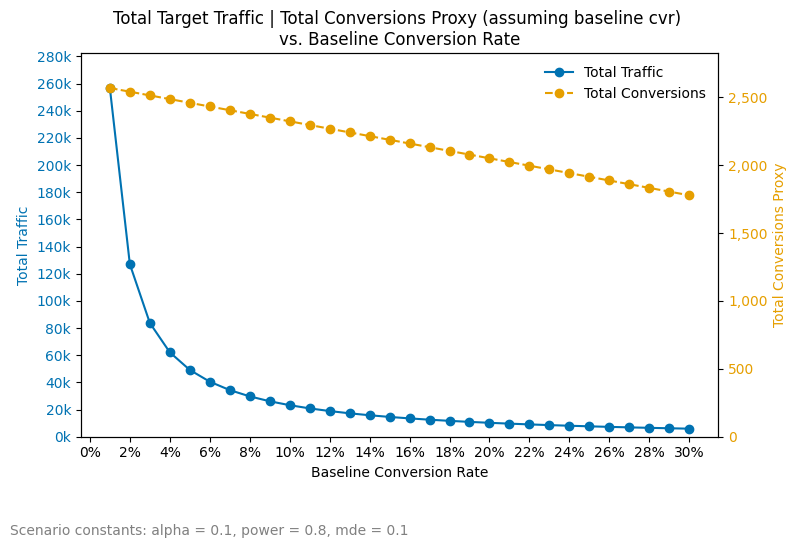

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Left axis — Total traffic
ax1.plot(
    results_df['baseline_rate'],
    results_df['total_traffic'],
    'o-', color='#0072B2',
    label='Total Traffic'
)
ax1.set_xlabel('Baseline Conversion Rate')
ax1.set_ylabel('Total Traffic', color='#0072B2')
ax1.tick_params(axis='y', labelcolor='#0072B2')
ax1.set_ylim(0, results_df['total_traffic'].max() * 1.1)

# Format left y axis
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1_000:.0f}k"))
ax1.yaxis.set_major_locator(mticker.MultipleLocator(20_000))

# Format x axis as percent
ax1.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
ax1.xaxis.set_major_locator(mticker.MultipleLocator(0.02))

# Right axis — Total conversions
ax2 = ax1.twinx()
ax2.plot(
    results_df['baseline_rate'],
    results_df['total_conversions'],
    'o--', color='#E69F00',
    label='Total Conversions'
)
ax2.set_ylabel('Total Conversions Proxy', color='#E69F00')
ax2.tick_params(axis='y', labelcolor='#E69F00')
ax2.set_ylim(0, results_df['total_conversions'].max() * 1.1)

# Format right y axis
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
ax2.yaxis.set_major_locator(mticker.MultipleLocator(500))

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, frameon=False, loc='upper right')

fig.text(
    0.01, -0.08,
    "Scenario constants: alpha = 0.1, power = 0.8, mde = 0.1",
    fontsize=10, color="gray", ha="left"
)

plt.title('Total Target Traffic | Total Conversions Proxy (assuming baseline cvr) \nvs. Baseline Conversion Rate')
plt.tight_layout()
plt.show()

#### Practical Example: Where to Trigger Experiment Inclusion

- Context setup:
    - For simplicity, let's assume that all users who convert must go through each stage of the funnel below:
        - Landing page
        - Product view
        - Add to cart
        - Checkout start
        - Payment info selection
        - Payment submission
        - Conversion
    - Given the above assumption, the absolute count of users who end up with a converion at the final step is equal at each funnel step.
- Key Takeaway: for funnel steps with baseline conversion rates between 1% and 20%, triggering experiments lower in the funnel, when applicable, offers only modest runtime reduction. Large runtime reduction observed when comparing baseline conversion rate 1% vs 50%.

In [58]:
# fake/example scenario data
data = {
    "landing_page_traffic": 20000,
    "product_view_rate": 0.60,       
    "add_to_cart_rate": 0.25,        
    "checkout_start_rate": 0.10,     
    "payment_info_selected_rate": 0.05,
    "payment_submitted_rate": 0.02,  
    "conversion_rate": 0.01 # successful payment and conversion logged         
}

daily_df = pd.DataFrame([data])

# Calculate each funnel step's count based on the base landing_page_traffic and stepwise rates
daily_df['product_views_count'] = (daily_df['landing_page_traffic'] * daily_df['product_view_rate']).astype(int)
daily_df['add_to_cart_count'] = (daily_df['landing_page_traffic'] * daily_df['add_to_cart_rate']).astype(int)
daily_df['checkout_starts_count'] = (daily_df['landing_page_traffic'] * daily_df['checkout_start_rate']).astype(int)
daily_df['payment_info_selected_count'] = (daily_df['landing_page_traffic'] * daily_df['payment_info_selected_rate']).astype(int)
daily_df['payment_submitted_count'] = (daily_df['landing_page_traffic'] * daily_df['payment_submitted_rate']).astype(int)
daily_df['conversions_count'] = (daily_df['landing_page_traffic'] * daily_df['conversion_rate']).astype(int)

# Arrange columns: landing_page_traffic, funnel counts, then funnel rates
daily_df = daily_df[
    [
        'landing_page_traffic',
        'product_views_count',
        'add_to_cart_count',
        'checkout_starts_count',
        'payment_info_selected_count',
        'payment_submitted_count',
        'conversions_count',
        'product_view_rate',
        'add_to_cart_rate',
        'checkout_start_rate',
        'payment_info_selected_rate',
        'payment_submitted_rate',
        'conversion_rate'
    ]
]

print("--------------------------------")
print("Daily Averages Example Data")
print("--------------------------------")
# Future TODO: format values for polished display
daily_df.T.rename(columns={0: 'value'})

--------------------------------
Daily Averages Example Data
--------------------------------


,value
landing_page_traffic,20000.00
product_views_count,12000.00
add_to_cart_count,5000.00
checkout_starts_count,2000.00
payment_info_selected_count,1000.00
payment_submitted_count,400.00
conversions_count,200.00
product_view_rate,0.60
add_to_cart_rate,0.25
checkout_start_rate,0.10


In [59]:
# build step n vs n-1 conversion rates helper data frame
steps = [
    'overall traffic to conversion', 
    'product view to conversion', 
    'add to cart to conversion', 
    'checkout start to conversion', 
    'payment info selected to conversion',
    'payment submitted to conversion'
]

conversion_rates = [
    daily_df['conversion_rate'].values[0],
    daily_df['conversions_count'].values[0] / daily_df['product_views_count'].values[0],
    daily_df['conversions_count'].values[0] / daily_df['add_to_cart_count'].values[0],
    daily_df['conversions_count'].values[0] / daily_df['checkout_starts_count'].values[0],
    daily_df['conversions_count'].values[0] / daily_df['payment_info_selected_count'].values[0],
    daily_df['conversions_count'].values[0] / daily_df['payment_submitted_count'].values[0]
]

traffic = [
    daily_df['landing_page_traffic'].values[0],
    daily_df['product_views_count'].values[0],
    daily_df['add_to_cart_count'].values[0],
    daily_df['checkout_starts_count'].values[0],
    daily_df['payment_info_selected_count'].values[0],
    daily_df['payment_submitted_count'].values[0]
]

step_conversion_rates = pd.DataFrame({
    'funnel_level': steps,
    'conversion_rate': np.round(conversion_rates, 4),
    'daily_traffic': traffic
})

# see context setup above for why daily conversion volume is equal at each funnel step
step_conversion_rates['daily_conversion_volume'] = (step_conversion_rates['daily_traffic'] * step_conversion_rates['conversion_rate']).astype(int)

# set funnel level as index
step_conversion_rates.set_index('funnel_level', inplace=True)

print("--------------------------------")
print("Step N Conversion Rate and Daily Totals")
print("--------------------------------")
# Future TODO: format values for polished display
step_conversion_rates

--------------------------------
Step N Conversion Rate and Daily Totals
--------------------------------


,conversion_rate,daily_traffic,daily_conversion_volume
funnel_level,,,
overall traffic to conversion,0.0100,20000,200
product view to conversion,0.0167,12000,200
add to cart to conversion,0.0400,5000,200
checkout start to conversion,0.1000,2000,200
payment info selected to conversion,0.2000,1000,200
payment submitted to conversion,0.5000,400,200


In [60]:
# build scenarios grid
scenarios_df = pd.DataFrame([
    ab_test_sample_requirements(
        baseline_rate,
        mde=0.1,
        alpha=0.1,
        power=0.8,
        conversions_per_day=daily_df['conversions_count'].values[0],
    )
    for baseline_rate in step_conversion_rates['conversion_rate']
])

# Use the step_conversion_rates index (which is 'funnel_level') as index for scenarios_df
scenarios_df.index = step_conversion_rates.index

# join in daily traffic in addition to conversion volume per day
scenarios_df = scenarios_df.join(step_conversion_rates[['daily_traffic']]).copy()

# estimated runtime based on traffic
scenarios_df['estimated_runtime_days_traffic'] = np.ceil((scenarios_df['by_group_required_sample_size'] * scenarios_df['num_groups']) / scenarios_df['daily_traffic']).astype(int)    

overall_row = scenarios_df.loc['overall traffic to conversion']

# compare funnel level to overall row for quick reference
scenarios_df['pct_change_vs_overall_traffic_level'] = scenarios_df['by_group_required_sample_size'].apply(
    lambda value: pct_change_funnel_level(value, overall_row['by_group_required_sample_size'])
)
scenarios_df['pct_change_vs_overall_conversions_proxy'] = scenarios_df['by_group_required_conversions_proxy'].apply(
    lambda value: pct_change_funnel_level(value, overall_row['by_group_required_conversions_proxy'])
)
scenarios_df['pct_change_vs_overall_runtime_days_conversion'] = scenarios_df['estimated_runtime_days_conversions'].apply(
    lambda value: pct_change_funnel_level(value, overall_row['estimated_runtime_days_conversions'])
)

# pct change vs overall runtime days based on traffic
scenarios_df['pct_change_vs_overall_runtime_days_traffic'] = scenarios_df['estimated_runtime_days_traffic'].apply(
    lambda value: pct_change_funnel_level(value, overall_row['estimated_runtime_days_traffic'])
)

In [61]:
# style and output scenarios grid
styled_df_scenarios = scenarios_df.copy()

# assumption rates
rate_cols_1 = ["baseline_rate", "mde", "alpha", "power"]
# column groups
count_cols = [
    "num_groups", "daily_traffic", "baseline_conversions_per_day",
    "by_group_required_sample_size", "by_group_required_conversions_proxy",
    "estimated_runtime_days_conversions", "estimated_runtime_days_traffic"
]

rate_cols_2 = [
    "pct_change_vs_overall_traffic_level",
    "pct_change_vs_overall_conversions_proxy",
    "pct_change_vs_overall_runtime_days_conversion",
    "pct_change_vs_overall_runtime_days_traffic"
]

format_rates = rate_cols_1 + rate_cols_2

# Format baseline_rate as x.xx% and others as usual (integer percent + %)
for col in format_rates:
    if col == "baseline_rate":
        styled_df_scenarios[col] = (styled_df_scenarios[col] * 100).round(2).map(lambda x: f"{x:.2f}%")
    else:
        styled_df_scenarios[col] = (styled_df_scenarios[col] * 100).round(0).astype(int).astype(str) + "%"

# format integers with thousands separators
for col in count_cols:
    styled_df_scenarios[col] = styled_df_scenarios[col].round(0).astype(int).apply(lambda x: f"{x:,}")

# reorder for clean `.T` output
styled_df_scenarios = styled_df_scenarios[
    rate_cols_1 +
    count_cols +
    rate_cols_2
]

styled_df_scenarios.T

funnel_level,overall traffic to conversion,product view to conversion,add to cart to conversion,checkout start to conversion,payment info selected to conversion,payment submitted to conversion
baseline_rate,1.00%,1.67%,4.00%,10.00%,20.00%,50.00%
mde,10%,10%,10%,10%,10%,10%
alpha,10%,10%,10%,10%,10%,10%
power,80%,80%,80%,80%,80%,80%
num_groups,2,2,2,2,2,2
daily_traffic,"20,000","12,000","5,000","2,000","1,000",400
baseline_conversions_per_day,200,200,200,200,200,200
by_group_required_sample_size,"128,391","76,335","31,076","11,613","5,126","1,232"
by_group_required_conversions_proxy,"1,284","1,275","1,243","1,161","1,025",616
estimated_runtime_days_conversions,13,13,13,12,11,7


#### Stats Breakdown: Importance of Conversion Volume

**Conversion AB Test Statistics**
- Statistical Test
    - 2 sample independent z proportion test (unpooled standard error)
- Define hypotheses
    - Null: A = B
    - Alterative: A != B
- Z Test Statistic
    - Effect Size: pB - pA
    - SE: SQRT(((pA * (1 - pA)) / sample_size_A) + ((pB * (1 - pB))  / sample_size_B))
    - Z Test Stat: Effect Size / SE
    - Z Test Stat Informally: Signal / Noise
- Z Critical Value
    - Number of standard deviations from the mean (of 0 on the standard normal curve) that leaves alpha/2 in each tail
    - Derived using code like norm.ppf(1 - alpha / 2) or a standard normal lookup table
- Test Evaluation
    - If absolute value of Z test stat >= Z critical value then we reject null in favor of alternative
- Pvalue
    - Assuming the null is true, probablity of observing a result at least as extreme by chance alone

**Conversion Volume and Standard Error**
- Higher conversion volume (via more traffic and/or a higher conversion rate) reduces the standard error, which increases test sensitivity. However, once the required power is reached, the additional benefit of conversion volume to test sensitivity/power tapers off and eventually plateaus.
- As expected, conversion volume is driven by conversion rate × traffic.
- In the Standard Error formula, note how SE will decrease as p and/or sample size increase.
- Explore the toggles below to build further intuition.

In [41]:
# --- Color-blind friendly palette (Okabe–Ito) ---
COLORS = {
    "se": "#0072B2",       # blue
    "power": "#E69F00",    # orange
}

plt.rcParams.update({
    "font.size": 11,
    "font.family": "sans-serif",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.4,
})

# Common layout fix so slider labels fully show
slider_layout = widgets.Layout(width="500px")
slider_style = {'description_width': '200px'}

# --- Widgets (horizontal, one per row) ---
p1_slider = widgets.FloatSlider(
    value=0.01, min=0.01, max=0.50, step=0.01,
    description="Baseline Conversion Rate (A):",
    orientation='horizontal',
    layout=slider_layout,
    style=slider_style,
    readout_format=".0%"
)

mde_slider = widgets.FloatSlider(
    value=0.10, min=0.01, max=0.50, step=0.01,
    description="MDE (relative to A):",
    orientation='horizontal',
    layout=slider_layout,
    style=slider_style,
    readout_format=".0%"
)

alpha_slider = widgets.FloatSlider(
    value=0.10, min=0.01, max=0.20, step=0.01,
    description="Alpha:",
    orientation='horizontal',
    layout=slider_layout,
    style=slider_style,
    readout_format=".0%"
)

max_n_slider = widgets.IntSlider(
    value=300_000, min=1_000, max=1_000_000, step=1_000,
    description="Max Traffic Per Group:",
    orientation='horizontal',
    layout=slider_layout,
    style=slider_style,
    readout_format=",d"
)

power_slider = widgets.FloatSlider(
    value=0.80, min=0.01, max=0.99, step=0.01,
    description="Power:",
    orientation='horizontal',
    layout=slider_layout,
    style=slider_style,
    readout_format=".0%"
)

# --- Plot ---
def plot_ab_test(p1, mde, alpha, max_n, power):
    n_min = 5_000
    n_points = 30
    n = np.linspace(n_min, max_n, n_points, dtype=int)

    p2 = p1 * (1 + mde)
    delta = p2 - p1
    z_crit = norm.ppf(1 - alpha / 2)

    df = (
        pd.DataFrame({"n": n})
        .assign(
            conv_A=lambda d: d.n * p1,
            conv_B=lambda d: d.n * p2,
            total_conv=lambda d: d.conv_A + d.conv_B,
            se=lambda d: np.sqrt(p1*(1-p1)/d.n + p2*(1-p2)/d.n),
            z=lambda d: delta / d.se,
            power=lambda d: norm.cdf(d.z - z_crit) + (1 - norm.cdf(d.z + z_crit)),
        )
    )

    fig, ax1 = plt.subplots(figsize=(8, 5))

    se_line, = ax1.plot(df.total_conv, df.se, marker="o", color=COLORS["se"], label="Standard Error")
    ax1.set_xlabel("Total Conversions Observed (A + B assuming MDE)")
    ax1.set_ylabel("Standard Error", color=COLORS["se"])
    ax1.tick_params(axis="y", labelcolor=COLORS["se"])

    ax2 = ax1.twinx()
    power_line, = ax2.plot(df.total_conv, df.power, marker="s", linestyle="--",
                           color=COLORS["power"], label="Power")
    ax2.set_ylabel("Power", color=COLORS["power"])
    ax2.tick_params(axis="y", labelcolor=COLORS["power"])
    ax2.set_ylim(0, 1)

    # horizontal target power line
    power_hline = ax2.axhline(power, color=COLORS["power"], linestyle=":",
                              linewidth=1.5, alpha=0.8,
                              label=f"Desired Power ({int(power*100)}%)")

    # Legend
    lines = [se_line, power_line, power_hline]
    labels = [line.get_label() for line in lines]
    ax1.legend(
        lines, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.12),
        ncol=3,
        frameon=False
    )

    plt.title("Conversion Volume Reduces Standard Error and Drives Test Sensitivity/Power\n\nTL;DR: More Conversions → Lower Standard Error → Increasing Power Until Plateau\n")
    plt.tight_layout()
    plt.show()

# --- Interactive UI (properly centered, no clipping) ---
controls = widgets.VBox([
    p1_slider,
    mde_slider,
    alpha_slider,
    max_n_slider,
    power_slider
], layout=widgets.Layout(align_items='center'))

out = widgets.interactive_output(
    plot_ab_test,
    dict(p1=p1_slider, mde=mde_slider, alpha=alpha_slider,
         max_n=max_n_slider, power=power_slider)
)

display(controls, out)

Output()